In [114]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import norm
import seaborn as sns
import pandas as pd

In [2]:
def Asian_Analytical(T, K, r, S0, sigma, N):
    
    '''
    Calculate Asian Option 
    Analytical expression for Asian call option based on geometric averages
    '''
    sigma_tilde = sigma * np.sqrt((2*N + 1)/(6*(N+1)))
    r_tilde = ((r - 0.5*sigma*sigma) + (sigma_tilde*sigma_tilde))/2
    d1 = (np.log(S0/K) + (r_tilde + 0.5*sigma_tilde**2)*T) /(np.sqrt(T)*sigma_tilde)
    d2 = (np.log(S0/K) + (r_tilde - 0.5*sigma_tilde**2)*T) /(np.sqrt(T)*sigma_tilde)
    
    
    return np.exp(-r*T) * (S0 * np.exp(r_tilde *T)*norm.cdf(d1) - K*norm.cdf(d2))

In [3]:
T = 1; K = 99; r = 0.06; S = 100; sigma = 0.2; trials = 10000; M = 1000; N=1000

In [4]:
True_Asian_geo = Asian_Analytical(T, K, r, S, sigma, N)
print(f"True value Geometric Asian Call Option: {True_Asian_geo}")
print(f"This value is verified from the TA for these values.")

True value Geometric Asian Call Option: 6.333989180142548
This value is verified from the TA for these values.


In [5]:
@jit(nopython=True, fastmath=True)
def GBM_Euler(T, K, S, sigma, r, M):
    '''
    Inputs: Time, Strike price, asset price, vol, interest rate, number of steps
    '''
    
    dt = T/M
    S_all = np.zeros(M)
    S_all[0] = S
    
    for i in range(1, M):
        S_all[i] = S_all[i-1] + r* S_all[i-1] * dt + sigma * S_all[i-1] * np.sqrt(dt) * np.random.normal()
    return S_all

In [6]:
T = 1; K = 99; r = 0.06; S = 100; sigma = 0.2; trials = 10000; M = 1000; N=1000
#T = 1; K = 29; r = 0.08; S = 30; sigma = 0.3; trials = 1000; M = 100; N=250

In [7]:
# https://stackoverflow.com/questions/43099542/python-easy-way-to-do-geometric-mean-in-python
def geo_mean_overflow(iterable):
    return  np.exp(np.log(iterable).mean())

In [109]:
def Control_Variate_Arith_Asian(T, K, r, S, sigma, trials, M, N, returnall=None):
    s_geo = np.zeros(trials)
    s_ar = np.zeros(trials)
    True_Asian_geo = Asian_Analytical(T, K, r, S, sigma, N)
    
    # Use one loop; if we use two separate GBMs, get high variance still
    for i in range(trials):
        test = GBM_Euler(T, K, S, sigma, r, M)
        s_geo[i] = np.max((0, geo_mean_overflow(test) - K))
        s_ar[i] = np.max((0, ((1/len(test)) * np.sum(test)) - K))


    V_MC_geo = np.mean(s_geo)
    var_geo = np.var(s_geo)
    CI_geo = [np.mean(s_geo) - 1.96*np.std(s_geo)/np.sqrt(len(s_geo)), np.mean(s_geo) + 1.96*np.std(s_geo)/np.sqrt(len(s_geo))]
    
    V_MC_arith = np.mean(s_ar)
    var_arith = np.var(s_ar)
    CI_arith = [np.mean(s_ar) - 1.96*np.std(s_ar)/np.sqrt(len(s_ar)), np.mean(s_ar) + 1.96*np.std(s_ar)/np.sqrt(len(s_ar))]

    # Compute optimal beta coefficient which minimizes the variance
    beta = (np.std(s_ar) / np.std(s_geo)) * np.corrcoef(s_ar, s_geo)[1][0]

    # Compute Control Variate estimate of arithmetic Asian call option
    arith_CV_est = V_MC_arith - beta*(V_MC_geo - True_Asian_geo)
         
    
    # Compute variance of CV estimate 
    # 1. alternative variance (use this one)
    arith_CV_var = var_arith - 2*beta*np.std(s_geo)*np.std(s_ar)* np.corrcoef(s_ar, s_geo)[1][0] + (beta**2)*var_geo
    
#     # 2. original one we used (but turns negative sometimes)
#     arith_CV_var_old = var_arith - ((np.cov((s_ar, s_geo))[1][0]**2 ) / var_geo)
#     # 3. alternative variance 
#     arith_CV_var_alt2 = (1/trials) * (var_arith - ((np.cov((s_ar, s_geo))[1][0]**2 ) / var_geo))
#     # 4. alternative variance, concsistent with nr 2.
#     arith_CV_var_alt3 = (1-np.corrcoef(s_ar, s_geo)[1][0]**2)*var_arith
    
    # Compute ratio variance of optimally controlled estimator to that of uncontrolled
#     ratio_variances = arith_CV_var / var_arith
    ratio_variances = 1 - np.corrcoef(s_ar, s_geo)[1][0]**2

    # Compute correlation coefficient
    corr = np.corrcoef(s_ar, s_geo)[1][0]

    if returnall is None:
        return arith_CV_est, arith_CV_var, ratio_variances, corr, V_MC_geo, var_geo, V_MC_arith, var_arith
    elif returnall == 1:
        return arith_CV_est, V_MC_arith
    elif returnall == 2:
        return arith_CV_est, ratio_variances
    elif returnall == 3:
        return ratio_variances
#     elif returnall ==4:
#         return arith_CV_var, arith_CV_var_alt, arith_CV_var_alt2, arith_CV_var_alt3
    return arith_CV_est


In [110]:
arith_CV_est, arith_CV_var, ratio_variances, corr, V_MC_geo, var_geo, V_MC_arith, var_arith = Control_Variate_Arith_Asian(T, K, r, S, sigma, trials, M, N)
print(f"Estimate of arithmetic Asian (using CV): {arith_CV_est}")
print(f"Variance of arithmetic Asian (using CV):  {arith_CV_var}")
print()
print(f"Analytical value Geometric Asian: {True_Asian_geo}")
print(f"Estimate of MC geometric Asian: {V_MC_geo}")
print(f"Estimate of MC arithmetic Asian: {V_MC_arith}")
print()
print(f"Ratio of variances ofoptimally controlled to uncontrolled estimator:{ratio_variances}")
print(f"Variance reduction factor: {1/ratio_variances}")
print()
print(f"Correlation, rho: {corr}")

Estimate of arithmetic Asian (using CV): 6.567437849852681
Variance of arithmetic Asian (using CV):  0.05570745915845521

Analytical value Geometric Asian: 6.333989180142548
Estimate of MC geometric Asian: 6.636339136560312
Estimate of MC arithmetic Asian: 6.879933094729013

Ratio of variances ofoptimally controlled to uncontrolled estimator:0.0007212839616796973
Variance reduction factor: 1386.416519883847

Correlation, rho: 0.9996392929643774


In [111]:
a=Control_Variate_Arith_Asian(T, K, r, S, sigma, 2230, M, N, returnall=2)
print(a)

(6.564777979212048, 0.0007905814031977654)


In [42]:
est_count = 50
CV_estimates_ar, MC_estimates_ar  = map(list,zip(*[Control_Variate_Arith_Asian(T, K, r, S, sigma, trials, M, N, returnall=1) for x in range(est_count)]))

In [43]:
print(len(CV_estimates_ar))


50


Text(0.5, 1.0, 'Comparison of CV estimates vs. MC estimates of arithmetic Asian call')

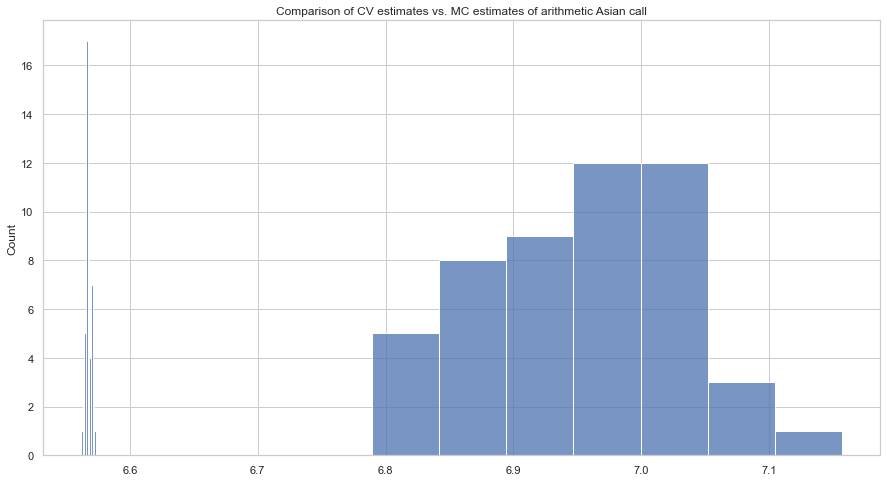

In [44]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("whitegrid")
sns.histplot(CV_estimates_ar)
sns.histplot(MC_estimates_ar)
plt.title("Comparison of CV estimates vs. MC estimates of arithmetic Asian call")

In [45]:
std_error_CV = np.std(CV_estimates_ar) / np.sqrt(est_count)
std_error_MC = np.std(MC_estimates_ar) / np.sqrt(est_count)
print(f"standard error CV: {std_error_CV}")
print(f"standard error MC: {std_error_MC}")

standard error CV: 0.0003036722180290435
standard error MC: 0.0114633998530417


### Experiment: effect of number of MC paths

In [69]:
# number of paths
distr_diff_paths_CV = []
var_ratios_paths_CV = []
paths = np.linspace(10, 10000, 2, dtype=int)

est_count = 50
for path in paths:   
    distr, var_ratios = map(list,zip(*[Control_Variate_Arith_Asian(T, K, r, S, sigma, path, M, N, returnall=2) for x in range(est_count)]))
    distr_diff_paths_CV.append(distr)
    var_ratios_paths_CV.append(var_ratios)

In [70]:
stderr_CV_pathlengths = []
for distr in distr_diff_paths_CV:
    std_error_CV = np.std(distr) / np.sqrt(est_count)
    stderr_CV_pathlengths.append(std_error_CV)

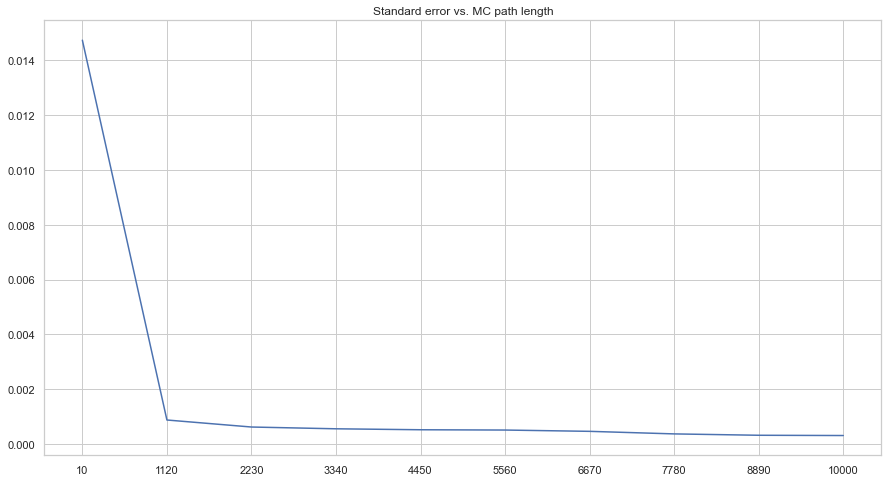

In [71]:
plt.plot(paths, stderr_CV_pathlengths)
plt.title("Standard error vs. MC path length")
plt.xticks(paths)
plt.show()

In [72]:
print(len(var_ratios_paths_CV))
print(var_ratios_paths_CV[0][0])

10
0.0002131320524930702


In [73]:
var_reduct_pathlengths = []
for red in var_ratios_paths_CV:
    # "red" holds 50 estimates of variance ratio, compute mean ratio, then compute (mean) var reduction
    var_reduction = 1/np.mean(red)
    var_reduct_pathlengths.append(var_reduction)

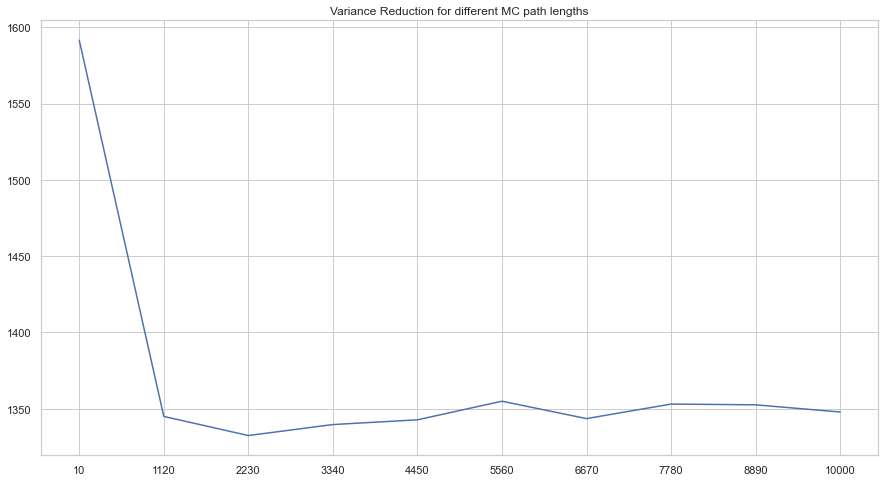

In [74]:
plt.plot(paths, var_reduct_pathlengths)
plt.title("Variance Reduction for different MC path lengths")
plt.xticks(paths)
plt.show()

In [117]:
CV_means = []
CV_errors = []
# Compute mean, confidence interval, and error
for distr in distr_diff_paths_CV:
    mean_CV = np.mean(distr)
    CI = [np.mean(distr) - 1.96*np.std(distr)/np.sqrt(len(distr)), np.mean(distr) + 1.96*np.std(distr)/np.sqrt(len(distr))]
    CV_error = 1.96*np.std(distr)/np.sqrt(len(distr))
    
    CV_means.append(mean_CV)
    CV_errors.append(CV_error)

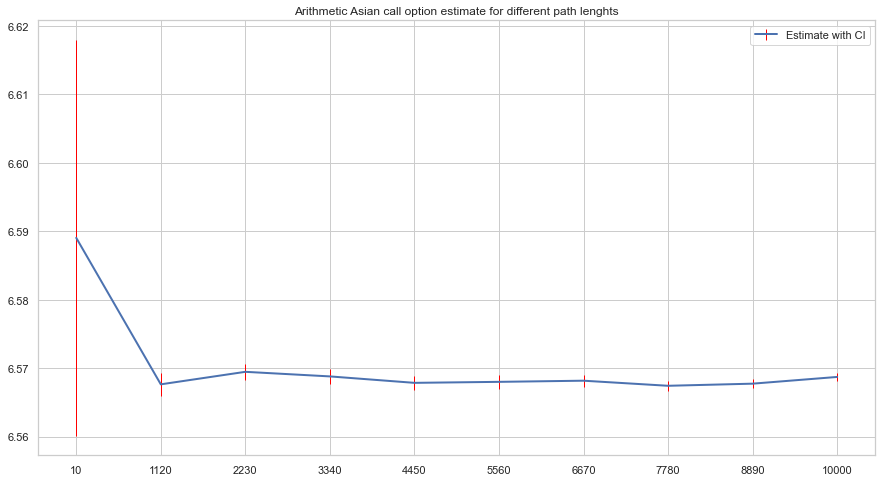

In [142]:
plt.errorbar(paths, CV_means, yerr=CV_errors, ecolor='red', linewidth=2, elinewidth= 1, label="Estimate with CI")
plt.xticks(paths)
plt.title("Arithmetic Asian call option estimate for different path lengths")
plt.legend()
plt.show()

In [216]:
stderr_paths = []
for distr in distr_diff_paths_CV:
    stderr = np.std(distr) / np.sqrt(len(distr_diff_paths_CV))
    stderr_paths.append(stderr)

In [217]:
print(len(distr_diff_paths_CV))

10


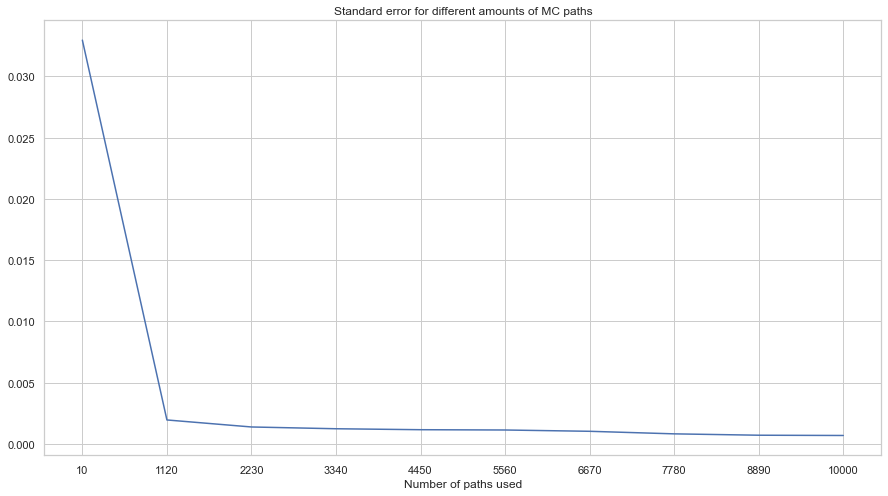

In [218]:
plt.plot(paths, stderr_paths)
plt.title("Standard error for different amounts of MC paths")
plt.xticks(paths)
plt.xlabel("Number of paths used")
plt.show()

### Experiment: effect of strike price

In [153]:
# strike prices
distr_diff_strikes_CV = []
var_ratios_strikes_CV = []
strikes = np.linspace(70, 130, 6, dtype=int)

est_count = 50
for strike in strikes:   
    distr, var_ratios = map(list,zip(*[Control_Variate_Arith_Asian(T, strike, r, S, sigma, trials, M, N, returnall=2) for x in range(est_count)]))
    distr_diff_strikes_CV.append(distr)
    var_ratios_strikes_CV.append(var_ratios)

In [154]:
var_reduct_strikes = []
for red in var_ratios_strikes_CV:
    # "red" holds 50 estimates of variance ratio, compute mean ratio, then compute (mean) var reduction
    var_reduction = 1/np.mean(red)
    var_reduct_strikes.append(var_reduction)

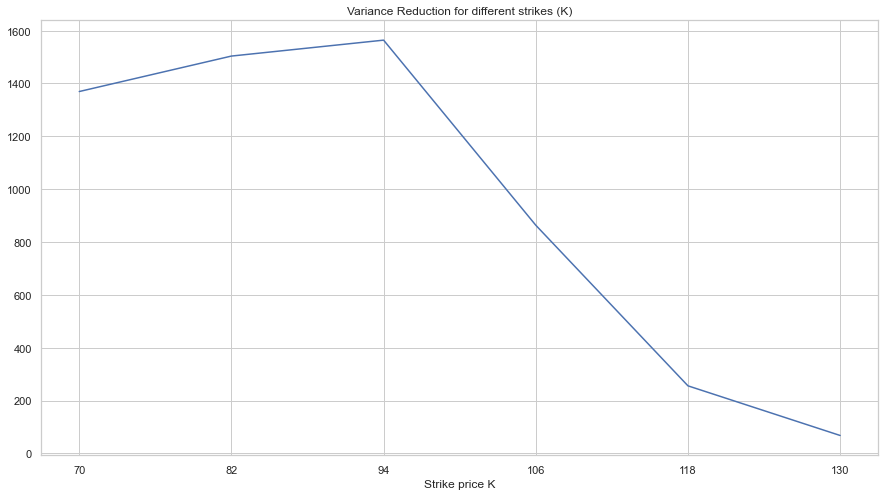

In [155]:
plt.plot(strikes, var_reduct_strikes)
plt.title("Variance Reduction for different strikes (K)")
plt.xticks(strikes)
plt.xlabel("Strike price K")
plt.show()

In [208]:
stderr_strikes = []
for distr in distr_diff_strikes_CV:
    stderr = np.std(distr) / np.sqrt(len(distr_diff_strikes_CV))
    stderr_strikes.append(stderr)

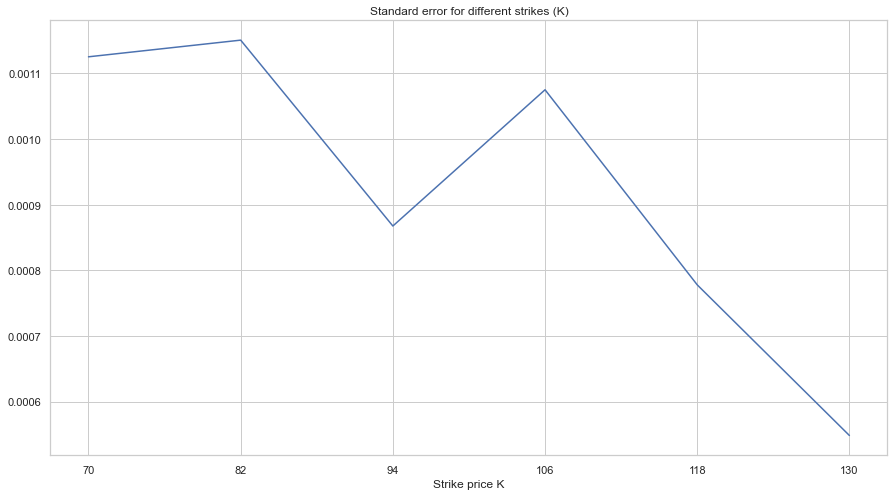

In [209]:
plt.plot(strikes, stderr_strikes)
plt.title("Standard error for different strikes (K)")
plt.xticks(strikes)
plt.xlabel("Strike price K")
plt.show()

### Experiment: number of time points used in the average

Basically means we just only a limited number of days to calculate the average value of S (instead of all)

In [204]:
T = 1; K = 99; r = 0.06; S = 100; sigma = 0.2; trials = 10000; M = 1000; N=1000

In [205]:
# option 1: calculating based on several time points with fixed number of days in between
# option2: calculating based on only the last few days (and varying this number)

In [206]:
# option 1:
def Control_Variate_Arith_Asian(T, K, r, S, sigma, trials, M, N, days=M, returnall=None):
    
    # control number of time points (days) to average over
    days_list = np.linspace(0, M-1, days, dtype=int)
    
    s_geo = np.zeros(trials)
    s_ar = np.zeros(trials)
    True_Asian_geo = Asian_Analytical(T, K, r, S, sigma, N)
    
    # Use one loop; if we use two separate GBMs, get high variance still
    for i in range(trials):
        
        test = GBM_Euler(T, K, S, sigma, r, M)
        s_geo[i] = np.max((0, geo_mean_overflow(test) - K))
        
        S_values = []
        for j in days_list:
            S_values.append(test[j])
        s_ar[i] = np.max((0, ((1/len(days_list)) * sum(S_values)) - K))
            

    V_MC_geo = np.mean(s_geo)
    var_geo = np.var(s_geo)
    CI_geo = [np.mean(s_geo) - 1.96*np.std(s_geo)/np.sqrt(len(s_geo)), np.mean(s_geo) + 1.96*np.std(s_geo)/np.sqrt(len(s_geo))]
    
    V_MC_arith = np.mean(s_ar)
    var_arith = np.var(s_ar)
    CI_arith = [np.mean(s_ar) - 1.96*np.std(s_ar)/np.sqrt(len(s_ar)), np.mean(s_ar) + 1.96*np.std(s_ar)/np.sqrt(len(s_ar))]

    # Compute optimal beta coefficient which minimizes the variance
    beta = (np.std(s_ar) / np.std(s_geo)) * np.corrcoef(s_ar, s_geo)[1][0]

    # Compute Control Variate estimate of arithmetic Asian call option
    arith_CV_est = V_MC_arith - beta*(V_MC_geo - True_Asian_geo)
         
    
    # Compute variance of CV estimate 
    # 1. alternative variance (use this one)
    arith_CV_var = var_arith - 2*beta*np.std(s_geo)*np.std(s_ar)* np.corrcoef(s_ar, s_geo)[1][0] + (beta**2)*var_geo
    
#     # 2. original one we used (but turns negative sometimes)
#     arith_CV_var_old = var_arith - ((np.cov((s_ar, s_geo))[1][0]**2 ) / var_geo)
#     # 3. alternative variance 
#     arith_CV_var_alt2 = (1/trials) * (var_arith - ((np.cov((s_ar, s_geo))[1][0]**2 ) / var_geo))
#     # 4. alternative variance, concsistent with nr 2.
#     arith_CV_var_alt3 = (1-np.corrcoef(s_ar, s_geo)[1][0]**2)*var_arith
    
    # Compute ratio variance of optimally controlled estimator to that of uncontrolled
#     ratio_variances = arith_CV_var / var_arith
    ratio_variances = 1 - np.corrcoef(s_ar, s_geo)[1][0]**2

    # Compute correlation coefficient
    corr = np.corrcoef(s_ar, s_geo)[1][0]

    if returnall is None:
        return arith_CV_est, arith_CV_var, ratio_variances, corr, V_MC_geo, var_geo, V_MC_arith, var_arith
    elif returnall == 1:
        return arith_CV_est, V_MC_arith
    elif returnall == 2:
        return arith_CV_est, ratio_variances
    elif returnall == 3:
        return ratio_variances
#     elif returnall ==4:
#         return arith_CV_var, arith_CV_var_alt, arith_CV_var_alt2, arith_CV_var_alt3
    return arith_CV_est



In [207]:
# Different spacings to average the S over
distr_diff_spacing_CV = []
var_ratios_spacing_CV = []
spacings = np.linspace(4, M, 10, dtype=int)

est_count = 50
for spacing in spacings:   
    distr, var_ratios = map(list,zip(*[Control_Variate_Arith_Asian(T, K, r, S, sigma, trials, M, N, spacing, returnall=2) for x in range(est_count)]))
    distr_diff_spacing_CV.append(distr)
    var_ratios_spacing_CV.append(var_ratios)

KeyboardInterrupt: 

In [ ]:
var_reduct_spacing = []
for red in var_ratios_spacing_CV:
    # "red" holds 50 estimates of variance ratio, compute mean ratio, then compute (mean) var reduction
    var_reduction = 1/np.mean(red)
    var_reduct_spacing.append(var_reduction)

In [ ]:
plt.plot(spacings, var_reduct_spacing)
plt.title("Variance Reduction for different number of time points to average the S_A over")
plt.xticks(spacings)
plt.xlabel("Number of time points (days) to average over")
plt.show()

#### Below also limited functionality, implement for standard error!

In [197]:
CV_means = []
CV_errors = []
# Compute mean, confidence interval, and error
for distr in distr_diff_spacing_CV:
    mean_CV = np.mean(distr)
    CI = [np.mean(distr) - 1.96*np.std(distr)/np.sqrt(len(distr)), np.mean(distr) + 1.96*np.std(distr)/np.sqrt(len(distr))]
    CV_error = 1.96*np.std(distr)/np.sqrt(len(distr))
    
    CV_means.append(mean_CV)
    CV_errors.append(CV_error)

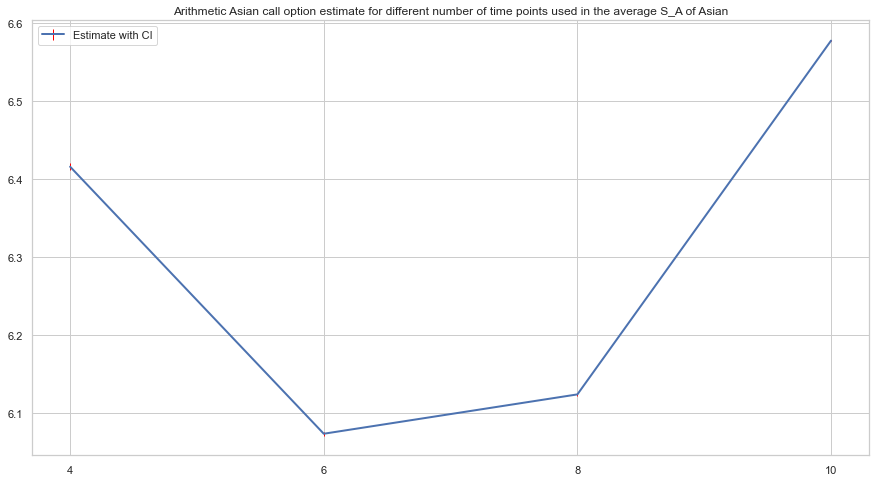

In [198]:
plt.errorbar(spacings, CV_means, yerr=CV_errors, ecolor='red', linewidth=2, elinewidth= 1, label="Estimate with CI")
plt.xticks(spacings)
plt.title("Arithmetic Asian call option estimate for different number of time points used in the average S_A of Asian")
plt.legend()
plt.show()

In [ ]:
stderr_spacing = []
for distr in distr_diff_spacing_CV:
    stderr = np.std(distr) / np.sqrt(len(distr_diff_spacing_CV))
    stderr_strikes.append(stderr)

In [203]:
plt.plot(spacings, stderr_spacing)
plt.title("Standard error for different number of time points to calculate average S_A")
plt.xticks(strikes)
plt.xlabel("Number of time points to calculate average S_A")
plt.show()

[ 4  4  5  6  6  7  8  8  9 10]
